In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import os
import json
from pandas.io.json import json_normalize
import warnings
warnings.filterwarnings('ignore')


In [2]:
#open and loading the anonymized_project file
with open('../data/anonymized_project.json') as f:
    j = json.load(f)
data=j['results']['root_node']['results']
df = pd.json_normalize(data.values()).apply(pd.Series.explode).reset_index(drop=True)
# remove and normalize the column of dictionaries, and join the result to df
df = df.join(pd.json_normalize(df.pop('results')))
#here we should drop project_node_input_id' record from the df, here i assume the input id should be unique
df = df.drop_duplicates(subset='project_node_input_id', keep="first")
df


,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url
0,discrete_answer,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...
10,discrete_answer,2021-02-25T13:53:31.698130+00:00,5,0.0,9d8a2527-accb-40bd-90d8-a73f20a609be,0000de80-97c8-40f4-aee1-f30377174381,9d8a2527-accb-40bd-90d8-a73f20a609be,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1044,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...
20,discrete_answer,2021-02-25T13:35:02.076869+00:00,5,0.0,0625d00c-96c3-41ad-9324-37037ffd0325,00023262-3608-4678-8d3f-142e6758fadb,0625d00c-96c3-41ad-9324-37037ffd0325,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,848,vendor_01,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,https://qm-auto-annotator.s3.eu-central-1.amaz...
30,discrete_answer,2021-02-26T03:53:40.752056+00:00,5,0.0,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,00036ee9-f7da-4753-9607-7df7b57d4623,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1077,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,https://qm-auto-annotator.s3.eu-central-1.amaz...
40,discrete_answer,2021-02-25T10:19:19.501386+00:00,5,0.0,363aaded-07f3-41b1-8c84-4bae83406757,000468b7-a24c-435c-b506-9db1bf3c700d,363aaded-07f3-41b1-8c84-4bae83406757,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1742,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90820,discrete_answer,2021-02-26T04:06:28.213617+00:00,5,0.0,0ea47243-a5ba-4bea-a61e-632ca41ab503,8c3b0939-0ea0-4326-b32c-525e026f74d4,0ea47243-a5ba-4bea-a61e-632ca41ab503,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,918,vendor_01,32971d11-e972-4d73-99a6-0847e1261995,annotator_18,https://qm-auto-annotator.s3.eu-central-1.amaz...
90830,discrete_answer,2021-02-25T12:50:45.388598+00:00,5,0.0,9ac9d365-9dd7-44fc-9e3e-5772110bb217,8df11808-4d11-49b7-97ff-3a61f618f45c,9ac9d365-9dd7-44fc-9e3e-5772110bb217,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1415,vendor_01,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,https://qm-auto-annotator.s3.eu-central-1.amaz...
90840,discrete_answer,2021-02-25T15:10:56.190173+00:00,5,0.0,bf4f4d43-de3b-46ef-8ed4-4d04d4641187,92ccde6e-1302-40e1-9f82-454179b7f1ae,bf4f4d43-de3b-46ef-8ed4-4d04d4641187,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1047,vendor_01,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,https://qm-auto-annotator.s3.eu-central-1.amaz...
90850,discrete_answer,2021-02-25T14:42:36.468576+00:00,5,0.0,cfa36c30-31ab-4647-bbc0-7e505db482ac,93799099-e674-43c3-a3e8-d8b872aad0eb,cfa36c30-31ab-4647-bbc0-7e505db482ac,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,911,vendor_01,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,https://qm-auto-annotator.s3.eu-central-1.amaz...


In [3]:
result=[]
#data=j['results']['root_node']['results']
for i in data:
    result.append(i)
len(result)   
        
    

9087

In [4]:
#data

In [5]:
#find duplicate rows across all columns
df.project_node_input_id.value_counts()

7e8984b6-dff7-4015-865a-b721a2faf681    1
9153693c-94ae-4005-9df0-0482445c342f    1
a9884010-3aa2-4646-af57-920e8fbdd81d    1
ff14b696-efdb-4aa6-8163-deb9c1a8eb36    1
d8719a33-0387-4a2f-9b2e-8487dd87e121    1
                                       ..
87ef6702-9308-4b19-9926-63a2d23114cd    1
2199024b-eb60-4585-9d77-9cfb064bb0bb    1
7b30f924-c1ed-402b-9466-5b737cf820fc    1
abe9e78f-1142-4773-9df3-5de7b0634af8    1
3db139c1-7fec-44b3-b770-a790bfcff241    1
Name: project_node_input_id, Length: 9087, dtype: int64

In [6]:
with open('../data/references.json') as f:
    j1 = json.load(f)
df1 = pd.json_normalize(j1).T
df1=pd.json_normalize(j1,max_level=0).T
df1.columns=['result']
# Create a new column with index values
#df1['img'] = df1.index

#using reset_index() to set index into column
df2=df1.reset_index()
df2=df2.rename(columns={'index':'img'})
df2=pd.concat([df2.drop(['result'], axis=1), df2['result'].apply(pd.Series)], axis=1)
df2.head()


,img,is_bicycle
0,img_4686,False
1,img_8607,True
2,img_5541,False
3,img_3218,False
4,img_3247,True


In [7]:
df_new=df.join(df2).reset_index(drop=True)
df_new.head()

,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,img,is_bicycle
0,discrete_answer,2021-02-25T14:08:11.319438+00:00,5,0.0,7e8984b6-dff7-4015-865a-b721a2faf681,0000439a-96ac-4bd4-8753-a4baa229ecf2,7e8984b6-dff7-4015-865a-b721a2faf681,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,997,vendor_01,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_4686,False
1,discrete_answer,2021-02-25T13:53:31.698130+00:00,5,0.0,9d8a2527-accb-40bd-90d8-a73f20a609be,0000de80-97c8-40f4-aee1-f30377174381,9d8a2527-accb-40bd-90d8-a73f20a609be,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1044,vendor_01,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3779,False
2,discrete_answer,2021-02-25T13:35:02.076869+00:00,5,0.0,0625d00c-96c3-41ad-9324-37037ffd0325,00023262-3608-4678-8d3f-142e6758fadb,0625d00c-96c3-41ad-9324-37037ffd0325,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,848,vendor_01,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_1546,True
3,discrete_answer,2021-02-26T03:53:40.752056+00:00,5,0.0,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,00036ee9-f7da-4753-9607-7df7b57d4623,a7c5595d-0ee0-4dea-bf6b-7ee3fb42d0e7,https://qm-auto-annotator.s3.eu-central-1.amaz...,no,False,False,1077,vendor_01,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_3780,False
4,discrete_answer,2021-02-25T10:19:19.501386+00:00,5,0.0,363aaded-07f3-41b1-8c84-4bae83406757,000468b7-a24c-435c-b506-9db1bf3c700d,363aaded-07f3-41b1-8c84-4bae83406757,https://qm-auto-annotator.s3.eu-central-1.amaz...,yes,False,False,1742,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...,img_8789,True


In [8]:
df_new.shape

(9087, 18)

In [9]:
df_new.to_csv('../data/finaldata.csv')

In [10]:
df_new=pd.read_csv('../data/finaldata.csv')

In [11]:
df_new.reset_index(drop=True)
df_new.drop(columns='Unnamed: 0',inplace=True)
df_new.shape

(9087, 18)

- The file contains 9087 records and 16 features.

### Data Cleaning and Preprossing

#### gui_type feature

In [12]:
df_new.gui_type.value_counts()

discrete_answer    9087
Name: gui_type, dtype: int64

- There is only one type of answer with 'gui_type'  so it will not help to us to anaysis data.
- 'task_input.image_url' and 'root_input.image_url' also not help for further data analysis.
 ### checking feature value dupication

In [13]:
df_new['project_node_input_id'].equals(df_new['project_root_node_input_id'])

True

##### Here 'project_node_input_id' column is duplicated with 'project_root_node_input_id' column,so decided to drop one of them.

In [14]:
df_new['task_output.cant_solve'].value_counts()

False    9085
True        2
Name: task_output.cant_solve, dtype: int64

In [15]:
df_new['task_output.corrupt_data'].value_counts()

False    9087
Name: task_output.corrupt_data, dtype: int64

- Here 'task_output.corrupt_data' have only one category 'False' ,so data is not correpted.

In [16]:
df_new.img.isnull().sum()

8178

In [17]:
df_new['is_bicycle'].isnull().sum()

8178

In [18]:
df_new['user.vendor_user_id'].isnull().sum()

0

In [19]:
df_new['user.vendor_id'].value_counts()

vendor_01    9087
Name: user.vendor_id, dtype: int64

- Here 'user.vendor_id' have only one category,it will not help much for analysis ,decided to drop.

In [20]:
df_new['workpackage_total_size'].value_counts()


5    9082
1       2
2       2
3       1
Name: workpackage_total_size, dtype: int64

In [21]:
df_new['loss'].value_counts()

0.0    9087
Name: loss, dtype: int64

- Here 'Loss' column  also not giving much infromation,so decided to drop.

In [22]:
df_new['task_output.answer'].value_counts()


yes    4618
no     4467
Name: task_output.answer, dtype: int64

- Here the task out put almost eqally distributed.

In [23]:
df_new.loc[(df_new['task_output.answer']!='yes') & (df_new['task_output.answer'] != 'no')]

,gui_type,created_at,workpackage_total_size,loss,project_node_input_id,project_node_output_id,project_root_node_input_id,task_input.image_url,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.vendor_id,user.id,user.vendor_user_id,root_input.image_url,img,is_bicycle
7024,discrete_answer,2021-02-25T13:16:11.077555+00:00,5,0.0,035315c3-ef9b-47c9-b48a-a6dca661b38c,234248a6-016b-451d-9e77-110ae1e7c92f,035315c3-ef9b-47c9-b48a-a6dca661b38c,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,True,False,746,vendor_01,9fddf227-6680-42f5-aca5-533fc439c193,annotator_04,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,NaN
8710,discrete_answer,2021-02-25T10:10:08.355604+00:00,5,0.0,bc616814-9d98-4c9f-afcb-d921d166653a,46f706a4-39ad-443a-ba86-b23ec8a56cd4,bc616814-9d98-4c9f-afcb-d921d166653a,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,True,False,783,vendor_01,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,https://qm-auto-annotator.s3.eu-central-1.amaz...,NaN,NaN


In [24]:
df_new.loc[df_new['task_output.answer'] == '', 'task_output.answer'] = 'cant_solve&corrupt_data'
task_df=df_new.loc[(df_new['task_output.answer']!='yes') & (df_new['task_output.answer'] != 'no')].reset_index()
task_df.groupby('user.vendor_user_id')[['task_output.answer','task_output.cant_solve','task_output.corrupt_data']].sum()

,task_output.cant_solve,task_output.corrupt_data
user.vendor_user_id,,
annotator_04,1,0
annotator_20,1,0


#### Insights:
- There is no case with  corrupted data.Only two cases can't solved by some other reasons.


#### Dropping unnecessary columns

In [25]:
df = df_new.drop(columns=['gui_type', 'task_input.image_url','root_input.image_url','project_root_node_input_id',
                          'user.vendor_id','loss','project_node_input_id',
                          'project_node_output_id','img'],axis=1)
df.head()

,created_at,workpackage_total_size,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.id,user.vendor_user_id,is_bicycle
0,2021-02-25T14:08:11.319438+00:00,5,no,False,False,997,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,False
1,2021-02-25T13:53:31.698130+00:00,5,yes,False,False,1044,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,False
2,2021-02-25T13:35:02.076869+00:00,5,no,False,False,848,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,True
3,2021-02-26T03:53:40.752056+00:00,5,no,False,False,1077,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,False
4,2021-02-25T10:19:19.501386+00:00,5,yes,False,False,1742,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,True


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   created_at                9087 non-null   object
 1   workpackage_total_size    9087 non-null   int64 
 2   task_output.answer        9085 non-null   object
 3   task_output.cant_solve    9087 non-null   bool  
 4   task_output.corrupt_data  9087 non-null   bool  
 5   task_output.duration_ms   9087 non-null   int64 
 6   user.id                   9087 non-null   object
 7   user.vendor_user_id       9087 non-null   object
 8   is_bicycle                909 non-null    object
dtypes: bool(2), int64(2), object(5)
memory usage: 514.8+ KB


In [27]:
#  Print the columns with missing values
[col for col in df.columns if df[col].isnull().any()]

['task_output.answer', 'is_bicycle']

<Axes: >

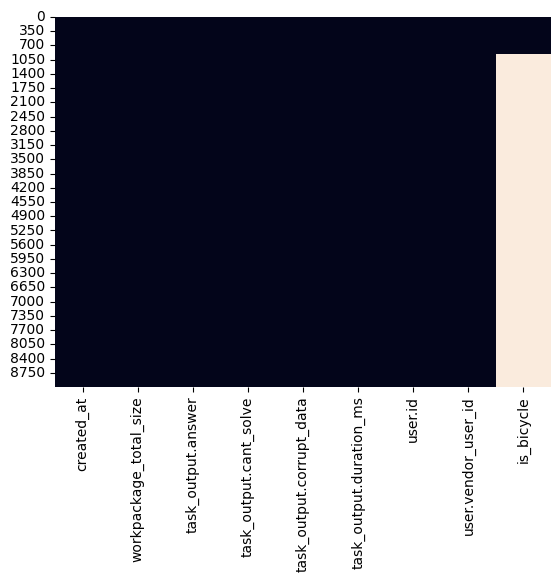

In [28]:
sns.heatmap(df.isnull(), cbar=False)

#### Insights:
- There are is_bicycle column(almost 90%) and 'task_output.answer'(2 instances) have null values.


#### filling null values with zero

In [29]:
df.fillna('no_output', inplace=True)
df.isnull().sum()

created_at                  0
workpackage_total_size      0
task_output.answer          0
task_output.cant_solve      0
task_output.corrupt_data    0
task_output.duration_ms     0
user.id                     0
user.vendor_user_id         0
is_bicycle                  0
dtype: int64

### Converting 'created_at'  columns to date time format

In [30]:
df['created_at'] = pd.to_datetime(df['created_at'], infer_datetime_format=True)
#df['task_output.duration_ms'] = pd.to_time(df['task_output.duration_ms'], unit = 'ms')
#df['task_output.duration_ms'] = pd.to_timedelta(df['task_output.duration_ms'])
#df['task_output.duration_ms']=df['task_output.duration_ms'].strftime('%s%f')[:-3]
df

,created_at,workpackage_total_size,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.id,user.vendor_user_id,is_bicycle
0,2021-02-25 14:08:11.319438+00:00,5,no,False,False,997,08af8775-a72c-4c59-b60f-9ce7df04fa92,annotator_12,False
1,2021-02-25 13:53:31.698130+00:00,5,yes,False,False,1044,62f1cf90-71c9-45c5-990c-f9dc0aa6ea3d,annotator_11,False
2,2021-02-25 13:35:02.076869+00:00,5,no,False,False,848,e336139c-5228-42cd-b501-81855532dfa6,annotator_05,True
3,2021-02-26 03:53:40.752056+00:00,5,no,False,False,1077,5765cc32-9e32-43e1-bd78-384cfd52d55a,annotator_06,False
4,2021-02-25 10:19:19.501386+00:00,5,yes,False,False,1742,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,True
...,...,...,...,...,...,...,...,...,...
9082,2021-02-26 04:06:28.213617+00:00,5,yes,False,False,918,32971d11-e972-4d73-99a6-0847e1261995,annotator_18,no_output
9083,2021-02-25 12:50:45.388598+00:00,5,yes,False,False,1415,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,no_output
9084,2021-02-25 15:10:56.190173+00:00,5,yes,False,False,1047,37a6036c-a9ef-4fcb-b554-7058f00415db,annotator_02,no_output
9085,2021-02-25 14:42:36.468576+00:00,5,no,False,False,911,6d8be901-c6a6-43f8-a5ac-8e44b924bd84,annotator_09,no_output


In [31]:
df['user.vendor_user_id'].value_counts().count()

22

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9087 entries, 0 to 9086
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   created_at                9087 non-null   datetime64[ns, UTC]
 1   workpackage_total_size    9087 non-null   int64              
 2   task_output.answer        9087 non-null   object             
 3   task_output.cant_solve    9087 non-null   bool               
 4   task_output.corrupt_data  9087 non-null   bool               
 5   task_output.duration_ms   9087 non-null   int64              
 6   user.id                   9087 non-null   object             
 7   user.vendor_user_id       9087 non-null   object             
 8   is_bicycle                9087 non-null   object             
dtypes: bool(2), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 514.8+ KB


In [33]:
## Function to visualise annotators
def annotator_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel('annatators')
    plt.ylabel('count')
    # Show graph
    plt.show()
#vendor_visual(filter_df,'user.vendor_user_id')    


In [76]:
##Function to calculate annotators percentage
def annot_percent(df,column):
    df_=df[column].value_counts().to_frame().reset_index().rename(columns={'index':'annotator'})
    df_['annotator %'] = ((df_[column] / df_[column] .sum())*100).round(2).astype(str) + '%'
    return df_

### Tasks
#### 1. Gather insights about the annotators:
 #### - a.  How many annotators did contribute to the dataset?

In [36]:
a=df['user.vendor_user_id'].value_counts().count()
print('The total annotators are contributing to the datase:', a)

The total annotators are contributing to the datase: 22


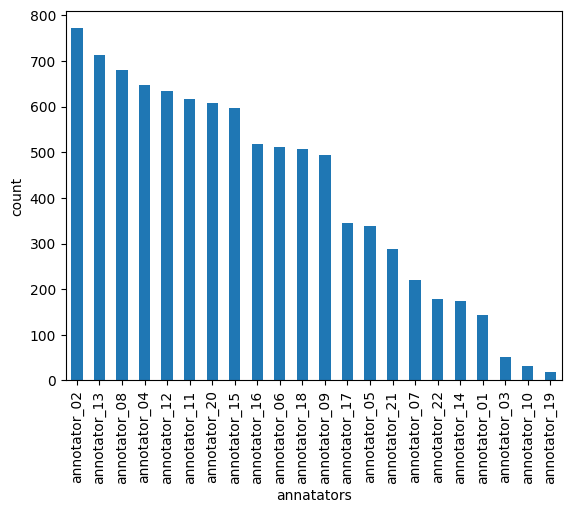

In [35]:
annotator_visual(df.copy(),'user.vendor_user_id') 

#### Insights from annotators class
- There are 22 annotators in total
-  The heighest number of jobs(771jobs) done by 'annotator-2' and the less work done by 'annotator-19(19jobs)'.




#### 1.b. What are the average, min and max annotation times (durations)? Feel free toadd visual representations here such as graphs if you like.

In [37]:
#df.groupby('user.vendor_user_id')['task_output.duration_ms'].agg()
df_time=df.groupby(['user.vendor_user_id'])['task_output.duration_ms'].agg([('Min' , 'min'), ('Max', 'max'),
                                                                                              ('mean','mean')]).add_prefix('tasktime_').reset_index().sort_values(['tasktime_Min',
                                                                                              'tasktime_Max','tasktime_mean'])
df_time


,user.vendor_user_id,tasktime_Min,tasktime_Max,tasktime_mean
19,annotator_20,70,7753,1179.331137
7,annotator_08,166,14310,1413.185022
21,annotator_22,349,3300,890.217877
10,annotator_11,479,11079,1256.322528
9,annotator_10,486,7302,1284.709677
16,annotator_17,495,3583,986.675362
20,annotator_21,495,9999,1193.451389
6,annotator_07,525,10672,1450.868182
8,annotator_09,558,13385,1199.093117
3,annotator_04,565,10389,1146.992272


### Insights

- Form the above data annotator_20 took min time 70ms to complete the task and annotator_14 took max time 24757 ms to complete task.
- Both cases the output answer is 'yes'.

### Lets see visually the max and min task time


<Axes: xlabel='user.vendor_user_id'>

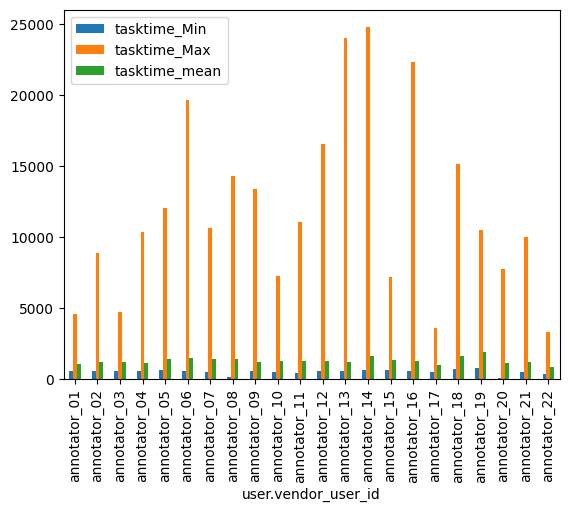

In [38]:
df_time.groupby(['user.vendor_user_id']).sum().plot(kind='bar')

#### Insignts
- Form the above data annotator_20 took min time 70ms to complete the task and annotator_14 took max time 24757 mins to complete task.
- Both cases the output answer is 'yes'.

#### Lets see visually the max and min task time

<Axes: xlabel='user.vendor_user_id'>

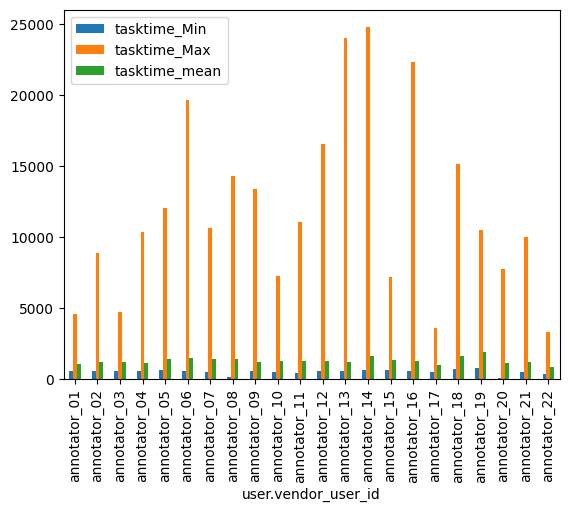

In [39]:
df_time.groupby(['user.vendor_user_id']).sum().plot(kind='bar')

#### 1.c. Did all annotators produce the same amount of results, or are there differences?

In [77]:
##Calling annot_percent function to calcutlate percentage
annot_percent(df.copy(),'user.vendor_user_id')

,annotator,user.vendor_user_id,annotator %
0,annotator_02,771,8.48%
1,annotator_13,712,7.84%
2,annotator_08,681,7.49%
3,annotator_04,647,7.12%
4,annotator_12,634,6.98%
5,annotator_11,617,6.79%
6,annotator_20,607,6.68%
7,annotator_15,597,6.57%
8,annotator_16,517,5.69%
9,annotator_06,512,5.63%


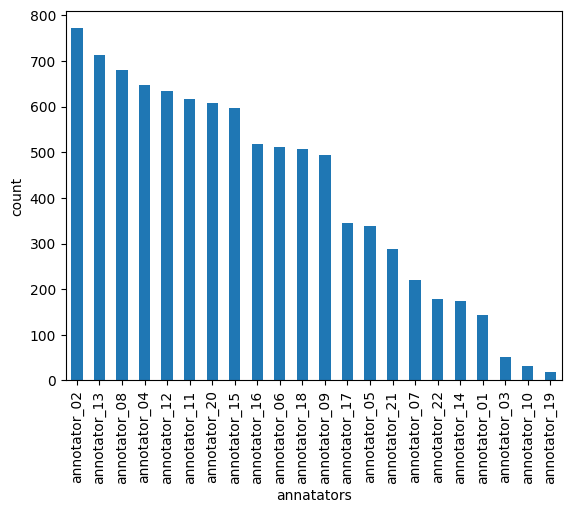

In [43]:
#calling annotator function
annotator_visual(df.copy(),'user.vendor_user_id')

#### Insights
- From the above analysis all annotators are not producing same amount of results.
- Annotator-2 is producing more results(8.48%).
- Annotatos -19 is producing least results(0.21%)

#### 2. Besides picking yes or no the annotators had the chance to tell if the data werecorrupted or if they for any reason were not able to solve the task. These are fields'cant_solve' and 'corrupt_data' given in the task_output.a. How often does each occur in the project and do you see a trend within theannotators that made use of these options?

In [51]:
df.loc[(df['task_output.answer']!='yes') & (df['task_output.answer'] != 'no')].reset_index(drop=True)

,created_at,workpackage_total_size,task_output.answer,task_output.cant_solve,task_output.corrupt_data,task_output.duration_ms,user.id,user.vendor_user_id,is_bicycle
0,2021-02-25 13:16:11.077555+00:00,5,no_output,True,False,746,9fddf227-6680-42f5-aca5-533fc439c193,annotator_04,no_output
1,2021-02-25 10:10:08.355604+00:00,5,no_output,True,False,783,0e606b41-ebe4-4d7d-996c-db910c84971a,annotator_20,no_output


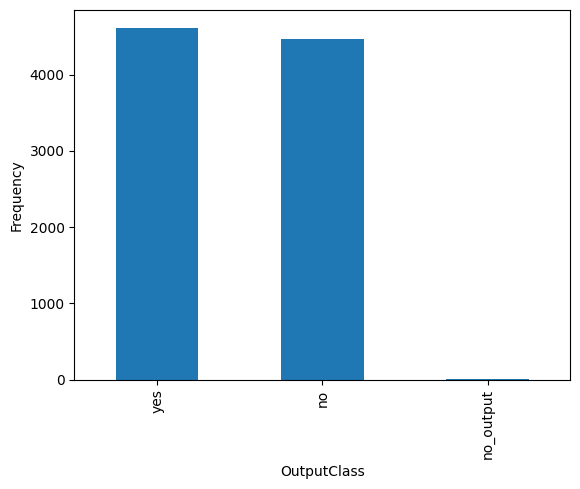

In [46]:
def task_output_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel("OutputClass")
    plt.ylabel("Frequency")
    # Show graph
    plt.show()
task_output_visual(df.copy(),'task_output.answer')

### Observations
- There are only two instances occured with can#t solve output .
- There are no instances that output corrupt_ data is true.

#### 3. Is the reference set balanced? Please demonstrate via numbers and visualizations.

In [47]:
df['is_bicycle'].value_counts().to_frame()

,is_bicycle
no_output,8178
True,462
False,447


### Insights
- From the above information more pecentage of data is missing.
- Lets see visually how data fall.

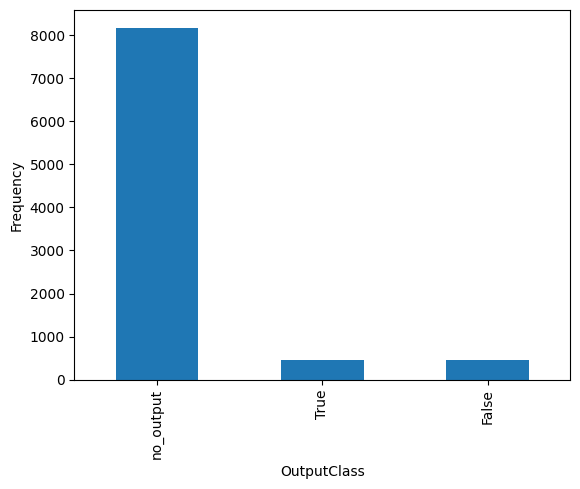

In [51]:
def is_bicycle_visual(df,column):
    col=column
    df[col] = df[col].value_counts().plot(kind='bar')
    #df[feature].value_counts().plot.bar(figsize = (8, 6))
    plt.xlabel("BiclycleClass")
    plt.ylabel("Frequency")
    # Show graph
    plt.show()
task_output_visual(df.copy(),'is_bicycle')

([<matplotlib.patches.Wedge at 0x27087c70130>,
 [Text(-1.0461269378609301, 0.3400271016870773, 'no_output'),
  Text(0.9813215409759307, -0.49699902737995866, 'True'),
  Text(1.0868909570886391, -0.16931641207792592, 'False')],
 [Text(-0.5706146933786891, 0.18546932819295123, '90.0%\n8178'),
  Text(0.5352662950777803, -0.2710903785708865, '5.1%\n462'),
  Text(0.5928496129574395, -0.09235440658795958, '4.9%\n447')])

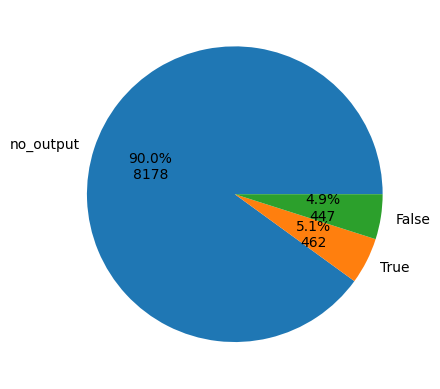

In [52]:
total = df['is_bicycle'].value_counts().values.sum()
def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(df['is_bicycle'].value_counts().values, labels=df['is_bicycle'].value_counts().index, autopct=fmt)

### Filter data with output values to further analysis

In [53]:
filter_df=df[df['is_bicycle']!='no_output']
filter_df = filter_df.filter(['user.vendor_user_id','task_output.answer','task_output.duration_ms','is_bicycle'], axis=1)
filter_df

,user.vendor_user_id,task_output.answer,task_output.duration_ms,is_bicycle
0,annotator_12,no,997,False
1,annotator_11,yes,1044,False
2,annotator_05,no,848,True
3,annotator_06,no,1077,False
4,annotator_20,yes,1742,True
...,...,...,...,...
904,annotator_21,yes,1118,False
905,annotator_14,no,854,True
906,annotator_12,no,1514,True
907,annotator_21,yes,967,True


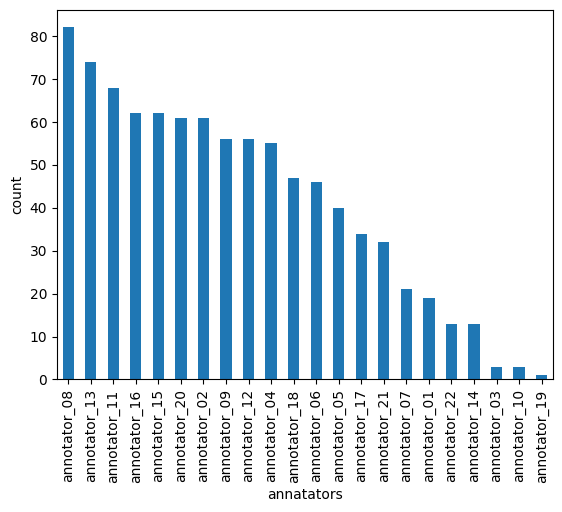

In [54]:
#Calling annotator function
annotator_visual(filter_df.copy(),'user.vendor_user_id')


In [85]:
#checking percentages of filtered annotators
annot_percent(filter_df.copy(),'user.vendor_user_id')

,annotator,user.vendor_user_id,annotator %
0,annotator_08,82,9.02%
1,annotator_13,74,8.14%
2,annotator_11,68,7.48%
3,annotator_16,62,6.82%
4,annotator_15,62,6.82%
5,annotator_20,61,6.71%
6,annotator_02,61,6.71%
7,annotator_09,56,6.16%
8,annotator_12,56,6.16%
9,annotator_04,55,6.05%


In [80]:
#A function to filter corect values by comaring task_output.answer and is_bicycle' column
def myFun(rec):
    if (rec['task_output.answer']== 'yes') & (rec['is_bicycle']==True):
        return 1
    elif (rec['task_output.answer']== 'no') & (rec['is_bicycle']==False):
        return 1
    
    return 0
   
filter_df['result']=filter_df.apply(myFun,axis=1)
    

In [81]:
filter_df

,user.vendor_user_id,task_output.answer,task_output.duration_ms,is_bicycle,result
0,annotator_12,no,997,False,1
1,annotator_11,yes,1044,False,0
2,annotator_05,no,848,True,0
3,annotator_06,no,1077,False,1
4,annotator_20,yes,1742,True,1
...,...,...,...,...,...
904,annotator_21,yes,1118,False,0
905,annotator_14,no,854,True,0
906,annotator_12,no,1514,True,0
907,annotator_21,yes,967,True,1


In [82]:
filter_df.result.value_counts()

0    459
1    450
Name: result, dtype: int64

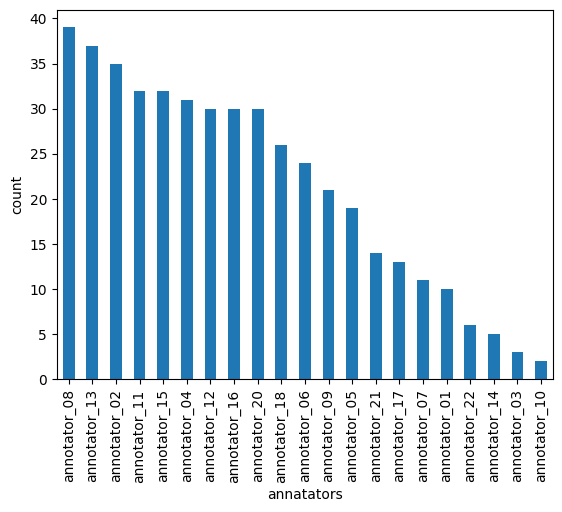

In [83]:
#To check  which annotator given more correct  results
true_df= filter_df[filter_df.result==1]
true_df
annotator_visual(true_df.copy(),'user.vendor_user_id')

In [86]:
#checking percentages of  true filtered annotators
annot_percent(true_df,'user.vendor_user_id')

,annotator,user.vendor_user_id,annotator %
0,annotator_08,39,8.67%
1,annotator_13,37,8.22%
2,annotator_02,35,7.78%
3,annotator_11,32,7.11%
4,annotator_15,32,7.11%
5,annotator_04,31,6.89%
6,annotator_12,30,6.67%
7,annotator_16,30,6.67%
8,annotator_20,30,6.67%
9,annotator_18,26,5.78%


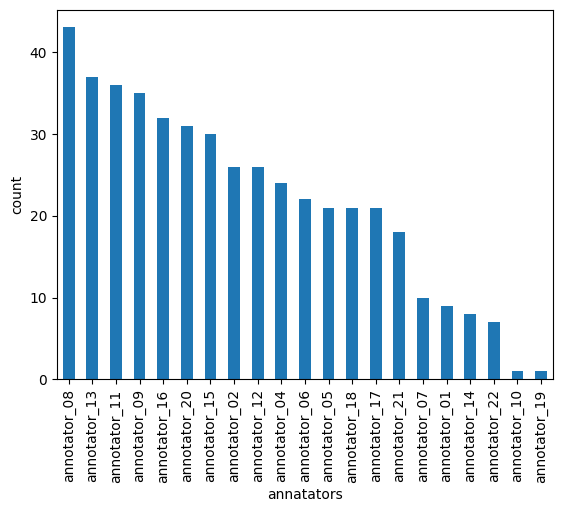

In [63]:
#To check  which annotator given more correct  results
false_df= filter_df[filter_df.result==0]
false_df
annotator_visual(false_df.copy(),'user.vendor_user_id')

In [87]:
annot_percent(false_df.copy(),'user.vendor_user_id')

,annotator,user.vendor_user_id,annotator %
0,annotator_08,43,9.37%
1,annotator_13,37,8.06%
2,annotator_11,36,7.84%
3,annotator_09,35,7.63%
4,annotator_16,32,6.97%
5,annotator_20,31,6.75%
6,annotator_15,30,6.54%
7,annotator_02,26,5.66%
8,annotator_12,26,5.66%
9,annotator_04,24,5.23%


In [110]:
##Checking whcih annotator contributed how may  results
df_=filter_df.groupby('user.vendor_user_id')['result'].value_counts().to_frame().rename(columns={'result':'count'})
df_=df_.reset_index()
df_.head()

,user.vendor_user_id,result,count
0,annotator_01,1,10
1,annotator_01,0,9
2,annotator_02,1,35
3,annotator_02,0,26
4,annotator_03,1,3


<Axes: xlabel='count', ylabel='user.vendor_user_id'>

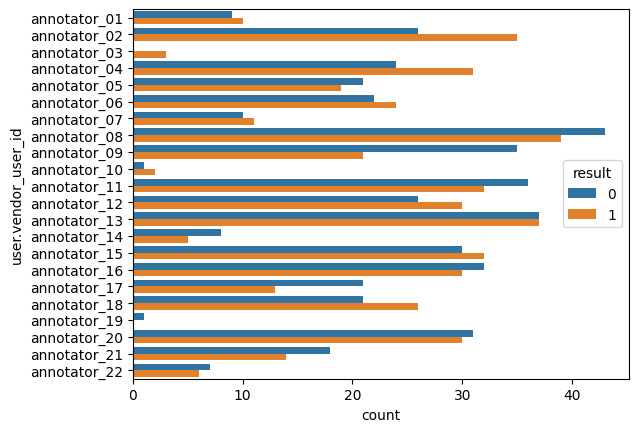

In [114]:
sns.barplot(data=df_, x='count', y='user.vendor_user_id', hue='result')